# G@C operating cost

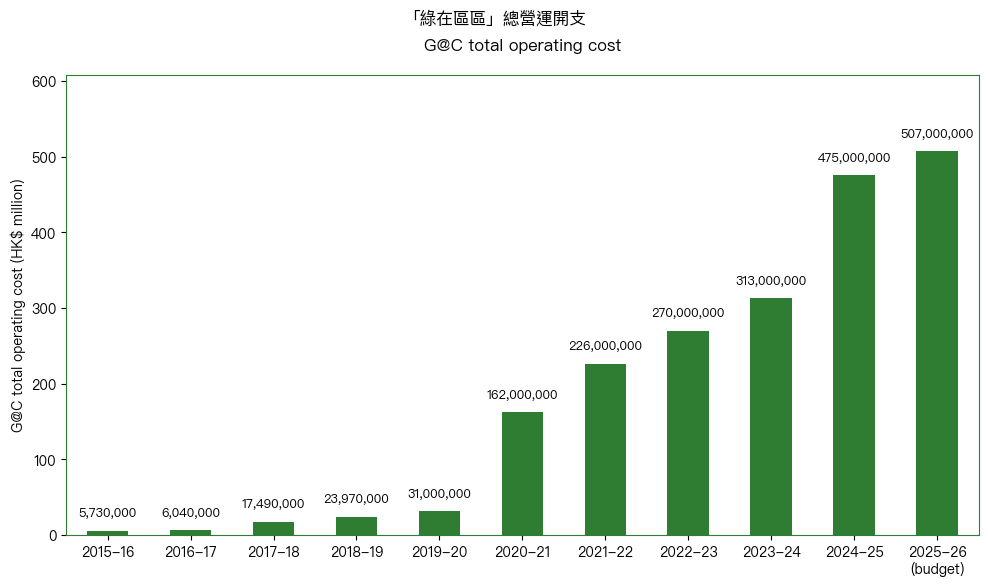

In [3]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data (specific sheet) ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
sheet_name = "G@C Recyclables Collection Volu"
df = pd.read_excel(data_path, sheet_name=sheet_name, engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        for p in patterns:
            if re.search(p, norm, flags=re.IGNORECASE):
                return c
    return None

year_patterns = [r"^year\b", r"年"]
cost_patterns = [r"g@c\s*total\s*operating\s*cost"]

year_col = find_col(df.columns, year_patterns)
cost_col = find_col(df.columns, cost_patterns)

if year_col is None or cost_col is None:
    raise RuntimeError("Could not find Year and/or 'G@C total operating cost' column.")

# ---------- clean and align data ----------
raw_years = df[year_col].astype(str)
raw_costs = df[cost_col].astype(str)

mask = raw_costs.str.strip().ne("") & raw_costs.notna()
years = raw_years[mask].str.strip().tolist()

# change "2025-26 (budget)" -> "2025-26\n(budget)" for nicer x-axis
years_display = [y.replace(" (budget)", "\n(budget)") for y in years]

costs = (
    raw_costs[mask]
    .str.replace(",", "", regex=False)
    .astype(float)
    .tolist()
)

costs_million = [c / 1_000_000 for c in costs]

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot vertical bar chart (green, with spacing) ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

x = range(len(years_display))
bar_color = "#2e7d32"  # green

for spine in ax.spines.values():
    spine.set_color(bar_color)

# narrower bars -> more visible space between bars
bars = ax.bar(x, costs_million, color=bar_color, width=0.5)

max_val = max(costs_million) if costs_million else 0
ax.set_ylim(0, max_val * 1.20 + 0.01)
ax.set_xlim(-0.5, len(years_display) - 0.5)

# add value labels above each bar
for xi, full_val, v_m in zip(x, costs, costs_million):
    ax.text(
        xi,
        v_m + max_val * 0.03,
        f"{full_val:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(years_display, rotation=0, ha="center")
ax.set_ylabel("G@C total operating cost (HK$ million)")

title_cn = "「綠在區區」總營運開支"
title_en = "G@C total operating cost"
fig.suptitle(title_cn, y=0.97)
ax.set_title(title_en, pad=18)

plt.tight_layout()
plt.show()
